In [1]:
import iris
import iris.coords
import datetime as dt
import os
import numpy as np
import matplotlib.pyplot as plt
import iris.plot as iplt
import cmocean
import cartopy.crs as ccrs
import warnings

In [3]:
os.chdir("/home/548/eh6215/Desktop/python/BARPA_evaluation/emma/lib")
from plotting_functions import bias_plots, ts_bias_rmse_plots
from load_cmip import load_cmip

In [4]:

cy=iris.Constraint(latitude=lambda y: -45<y<-10)
cx=iris.Constraint(longitude=lambda x: 110<x<155)
trials = {"cg282_ACCESS-CM2_historical_1979_r4p": ("CMIP6-ACCESS-CM2-historical-r4i1p1f1",np.arange(1980,1990)),
          "cg282_ACCESS-CM2_ssp370_2090_r4": ("CMIP6-ACCESS-CM2-ssp370-r4i1p1f1",np.arange(2090,2100)),
          "cg282_ACCESS-CM2_historical_1979_r6p": ("CMIP6-ACCESS-CM2-historical-r4i1p1f1",np.arange(1980,1990)),
          "cg282_ACCESS-CM2_ssp370_2090_r6":("CMIP6-ACCESS-CM2-ssp370-r4i1p1f1",np.arange(2090,2100))}

alpha_w = iris.coords.AuxCoord(1/1000.,units='m**3*kg**-1')

domains = {
           "SW_WA": (-30, -35,  110, 120),
           "SEQ_NSW": (-25,-30, 150,155),
           "SE_Aus": (-33, -45, 135, 150),
           "Top_End_Kimb": (-10,-17,120,135),
           "Central_Aus": (-23, -30, 130,140)}


topo=iris.load_cube("/home/548/eh6215/orog.nc",cx&cy)
lapse = iris.coords.AuxCoord(-6,units="K/km")




In [5]:
#Load trial datasets

data= {}
path = "/short/tp28/eh6215//monthly/{trial}/{year}_means.nc"
for trial in  ["cg282_ACCESS-CM2_historical_1979_r4p","cg282_ACCESS-CM2_ssp370_2090_r4","cg282_ACCESS-CM2_historical_1979_r6p","cg282_ACCESS-CM2_ssp370_2090_r6"]:
  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tmp = iris.load([path.format(trial=trial,year=year) for year in trials[trial][1]],cx&cy)
  iris.util.equalise_attributes(tmp)
  tmp = tmp.concatenate()
  trial=trial.split("_")[-1]
  data[trial] = {}
  for var in ['prcp','Tmax','Tmin']:
      data[trial][var] =tmp.extract_cube(var.lower())


In [6]:
# load Reference datasets

keys = {'historical':"CMIP_hist_long",'ssp370':"CMIP_ssp370"}
data["CMIP_hist_long"] = {}
data["CMIP_ssp370_long"] = {}
for scen in ['historical']:
#    data[keys[scen]] = {}
    year0,year1 = {'historical':[1950,2010],'ssp370':[2050,2100]}[scen]
    data[keys[scen]]['Tmin'] = load_cmip(scen,"ACCESS-CM2","Amon",'tasmin',dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,template=topo,lapse=lapse)
    data[keys[scen]]['Tmax'] = load_cmip(scen,"ACCESS-CM2","Amon",'tasmax',dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,template=topo,lapse=lapse)
    data[keys[scen]]['prcp'] = load_cmip(scen,"ACCESS-CM2","Amon",'pr',dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,template=topo)



keys = {'historical':"CMIP_hist",'ssp370':"CMIP_ssp370"}
data["CMIP_hist"] = {}
data["CMIP_ssp370"] = {}
for scen in ['historical','ssp370']:
#    data[keys[scen]] = {}
    year0,year1 = {'historical':[1980,1990],'ssp370':[2090,2100]}[scen]
    data[keys[scen]]['Tmin'] = load_cmip(scen,"ACCESS-CM2","Amon",'tasmin',dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,template=topo,lapse=lapse)
    data[keys[scen]]['Tmax'] = load_cmip(scen,"ACCESS-CM2","Amon",'tasmax',dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,template=topo,lapse=lapse)
    data[keys[scen]]['prcp'] = load_cmip(scen,"ACCESS-CM2","Amon",'pr',dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,template=topo)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tasmin'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'orog'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tasmax'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'orog'
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/iris

In [7]:
#mask = topo.data<=0
mask = topo.copy(data = np.ma.masked_array(np.ones(topo.shape), mask = topo.data <= 0))
mask.units=1
mask.rename("mask")
mask.remove_coord('time')
years = trials["cg282_ACCESS-CM2_historical_1979_r4p"][1]
data['ref'] = {}
for var in ['prcp','Tmax','Tmin','vapourpres_15'][:-1]:
  if var=='prcp':
    data['ref'][var] = iris.load(["/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_%d.nc"%year for year in years],cx&cy)
  else:
    data['ref'][var] = iris.load(["/g/data/zv2/agcd/v1/{t}/mean/r005/01month/agcd_v1_{t}_mean_r005_monthly_{year}.nc".format(year=year,t=var.lower()) for year in years],cx&cy)
  iris.util.equalise_attributes(data['ref'][var] )
  data['ref'][var] =data['ref'][var] .concatenate_cube()
  data['ref'][var].coord('longitude').coord_system=None
  data['ref'][var].coord('latitude').coord_system=None
  data['ref'][var] =data['ref'][var].regrid(data['r4p'][var],iris.analysis.Linear(extrapolation_mode='mask'))

In [8]:
years = range(1950,2010)
data['ref_long'] = {}
for var in ['prcp','Tmax','Tmin','vapourpres_15'][:-1]:
  if var=='prcp':
    data['ref_long'][var] = iris.load(["/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_%d.nc"%year for year in years],cx&cy)
  else:
    data['ref_long'][var] = iris.load(["/g/data/zv2/agcd/v1/{t}/mean/r005/01month/agcd_v1_{t}_mean_r005_monthly_{year}.nc".format(year=year,t=var.lower()) for year in years],cx&cy)
  iris.util.equalise_attributes(data['ref_long'][var] )
  data['ref_long'][var] =data['ref_long'][var] .concatenate_cube()
  data['ref_long'][var].coord('longitude').coord_system=None
  data['ref_long'][var].coord('latitude').coord_system=None
  data['ref_long'][var] =data['ref_long'][var].regrid(data['r4p'][var],iris.analysis.Linear(extrapolation_mode='mask'))



data['ref_long']['prcp'].units='mm/month'
data['ref']['prcp'].units='mm/month'
#data['ref']['prcp'].convert_units('mm/day')

In [9]:
def equalise_coords(cube):
    cube.coord('longitude').points =cube.coord('longitude').points.astype(np.float32)
    cube.coord('latitude').points  =cube.coord('latitude').points.astype(np.float32)
    cube.coord('longitude').coord_system = None
    cube.coord('latitude').coord_system = None


for key1 in data.keys():
    for key2 in data[key1].keys():
        equalise_coords(data[key1][key2])

equalise_coords(mask)

In [17]:
data['r4p']['prcp'][10,100,100].data
mask

<iris 'Cube' of mask / (1) (latitude: 227; longitude: 291)>

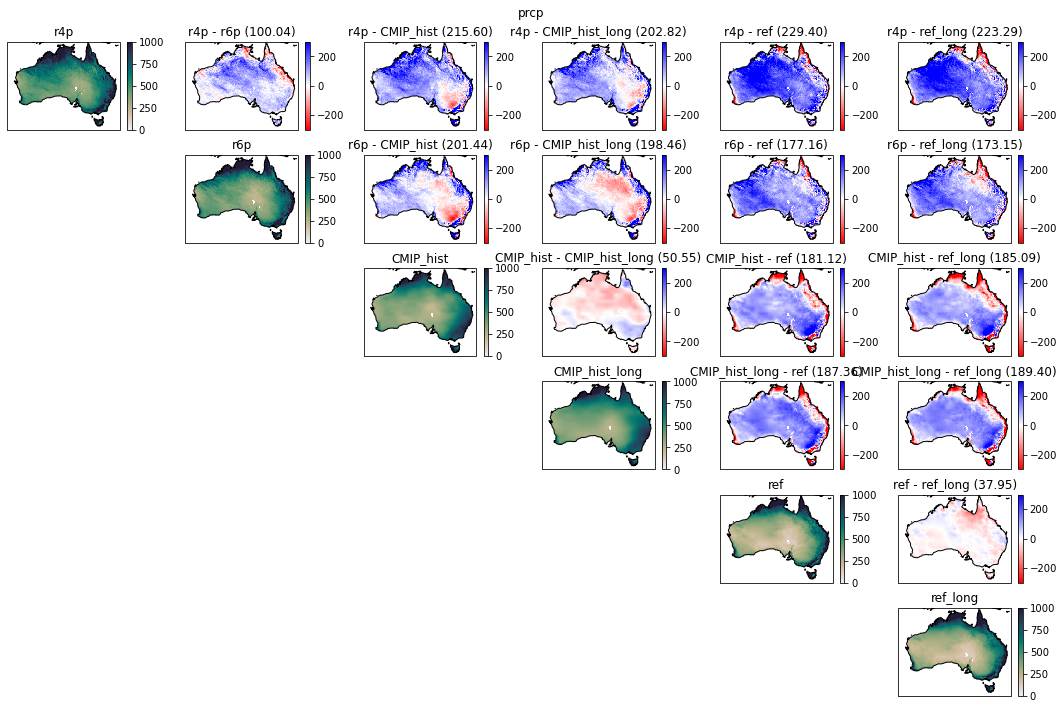

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.figure(figsize=(15,10))
    bias_plots(data,'prcp',mask.data.mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref','ref_long'],0,1000,300,cmocean.cm.rain,'bwr_r','mm/year')
    plt.tight_layout()


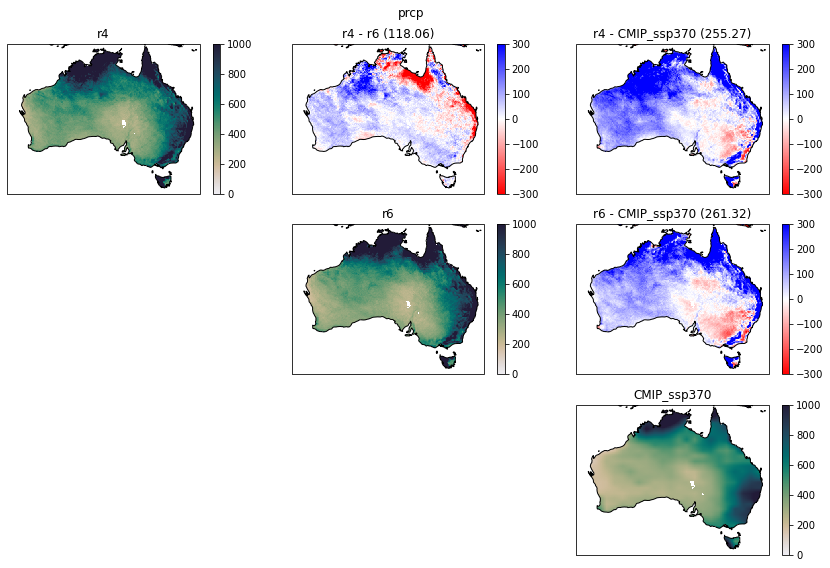

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plt.figure(figsize=(12,8))
    bias_plots(data,'prcp',mask.data.mask,['r4','r6','CMIP_ssp370'],0,1000,300,cmocean.cm.rain,'bwr_r','mm/year')
    plt.tight_layout()


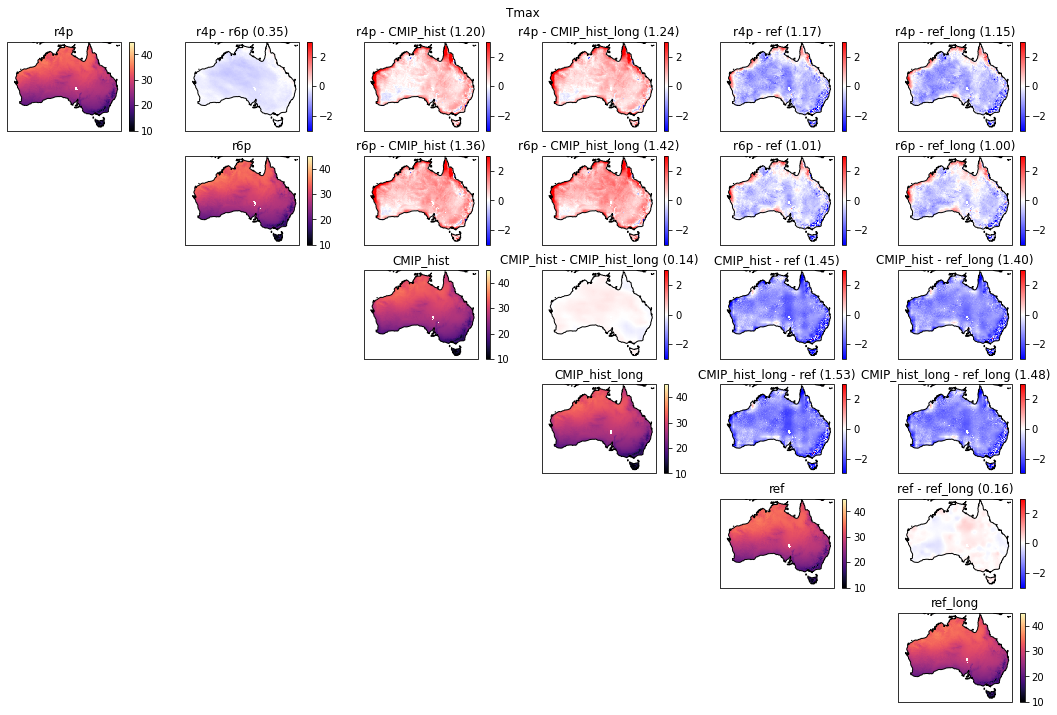

In [23]:
plt.figure(figsize=(15,10))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bias_plots(data,'Tmax',mask.data.mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref','ref_long'],10,45,3,'magma','bwr','Celsius')
    plt.tight_layout()


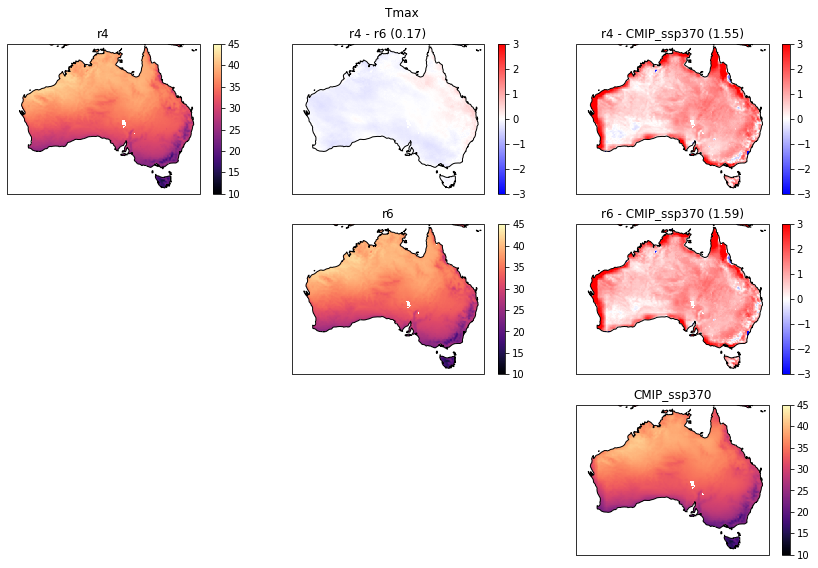

In [22]:
plt.figure(figsize=(12,8))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bias_plots(data,'Tmax',mask.data.mask,['r4','r6','CMIP_ssp370'],10,45,3,'magma','bwr','Celsius')
    plt.tight_layout()
    

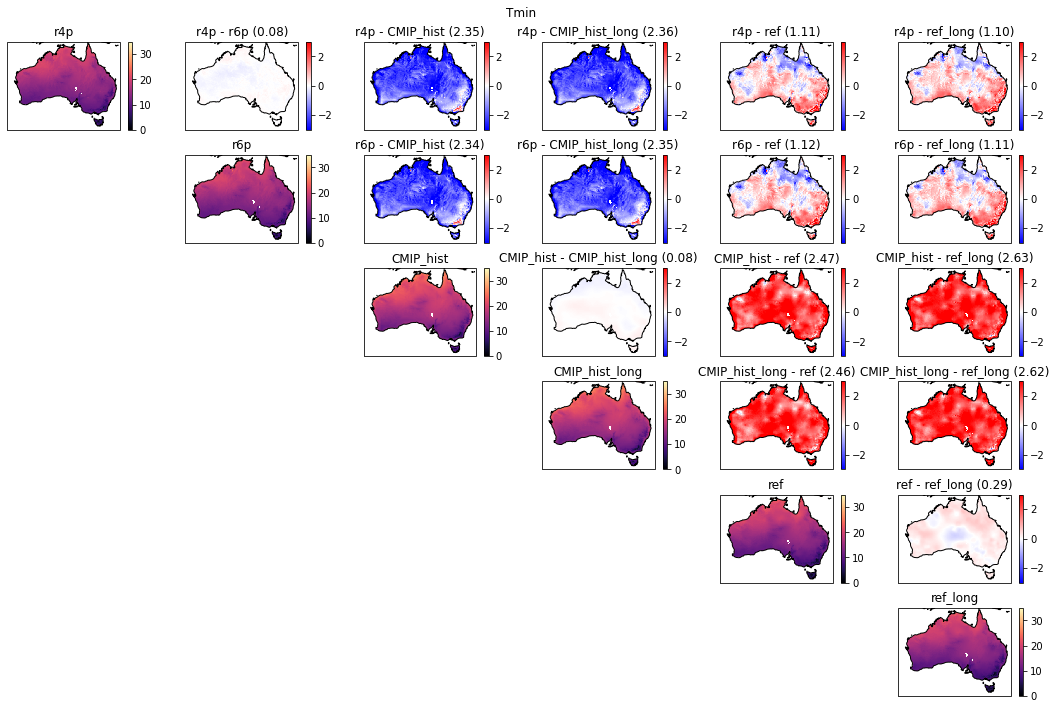

In [25]:
plt.figure(figsize=(15,10))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bias_plots(data,'Tmin',mask.data.mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref','ref_long'],0,35,3,'magma','bwr','Celsius')
    plt.tight_layout()


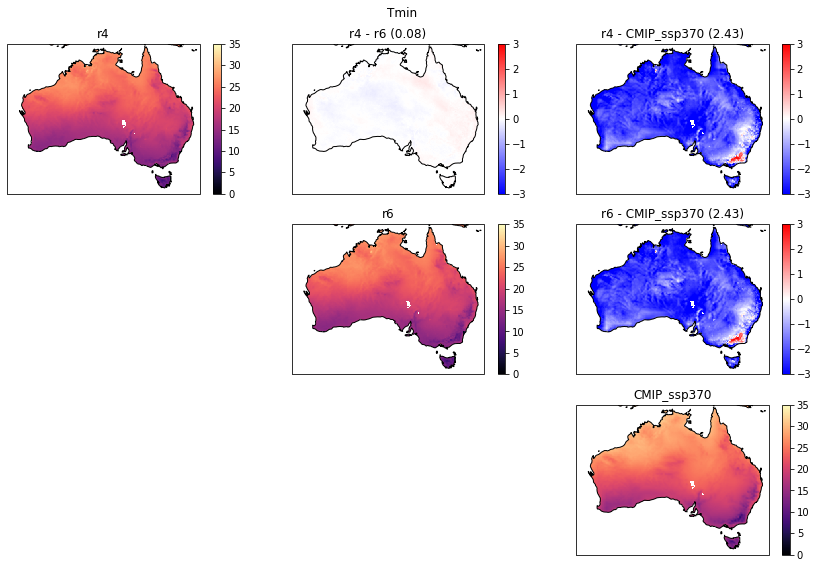

In [26]:
plt.figure(figsize=(12,8))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bias_plots(data,'Tmin',mask.data.mask,['r4','r6','CMIP_ssp370'],0,35,3,'magma','bwr','Celsius')
    plt.tight_layout()
    plt.show()

In [ ]:
for i,key in enumerate(domains):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        y1,y0,x0,x1 = domains[key]
        cx2 = iris.Constraint( latitude=lambda y: y0<=y<=y1)
        cy2 = iris.Constraint(longitude=lambda x: x0<=x<=x1)
        plt.figure()
        plt.suptitle(key)
        plt.subplot(3,5,1+3*i)
        plt.title('precip rmse')
        ts_bias_rmse_plots(data,'rmse','prcp',mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref_long'],'ref','mm/year',cx2&cy2)
        plt.subplot(3,5,2+3*i)
        plt.title('Tmax rmse')
        ts_bias_rmse_plots(data,'rmse','Tmax',mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref_long'],'ref','Celsius',cx2&cy2)
        plt.subplot(3,5,3+3*i)
        plt.title('Tmin rmse')
        ts_bias_rmse_plots(data,'rmse','Tmin',mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref_long'],'ref','Celsius',cx2&cy2)
    
    

In [11]:
for i,key in enumerate(domains):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        y1,y0,x0,x1 = domains[key]
        cx2 = iris.Constraint( latitude=lambda y: y0<=y<=y1)
        cy2 = iris.Constraint(longitude=lambda x: x0<=x<=x1)
        plt.figure()
        plt.suptitle(key)
        plt.subplot(3,5,1+3*i)
        plt.title('precip rmse')
        ts_bias_rmse_plots(data,'bias','prcp',mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref_long'],'ref','mm/year',cx2&cy2)
        plt.subplot(3,5,2+3*i)
        plt.title('Tmax rmse')
        ts_bias_rmse_plots(data,'bias','Tmax',mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref_long'],'ref','Celsius',cx2&cy2)
        plt.subplot(3,5,3+3*i)
        plt.title('Tmin rmse')
        ts_bias_rmse_plots(data,'bias','Tmin',mask,['r4p','r6p','CMIP_hist','CMIP_hist_long','ref_long'],'ref','Celsius',cx2&cy2)
    